In [168]:

import torch
from torch import nn, Tensor, no_grad, save, load
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from PIL import Image

import os
import pandas as pd
import numpy as np
import time
from tqdm import tqdm

from typing import Callable, List, Tuple

In [169]:
df = pd.read_csv("used_clothes.csv")
df.drop(columns=["description", "Material", "Occasion", "Length", "Size", "Brand", "Seasons", "Gender", "Fit"], inplace=True)

In [170]:
class ClothesDataset(Dataset):
    def __init__(self, 
            df:pd.DataFrame, 
            label_column: str,
            labels:List[str],
            transform:Callable[[np.ndarray], Tensor]=transforms.ToTensor(), 
            path_images:str="./data", 
            filename_column: str='file_name', 
        ) -> None:
        if label_column not in df.columns:
            raise ValueError(f"label column '{label_column}' not found in DataFrame")      
        self.path_files = path_images
        self.label_column = label_column
        self.filename_column = filename_column
        self.labels = labels
        self.df = df.dropna(subset=[label_column])  # remove linhas sem categoria
        self.transform = transform
        
        self.parse_label = {}
        self.parse_label = {label: idx for idx, label in enumerate(labels)}

    def __len__(self) -> int:
        return len(self.df)
    
    def num_labels(self) -> int:
        return len(self.labels)
    
    def true_labels(self, indexed:bool=False) -> List[str]:
        if indexed:
            return self.df[self.label_column].apply(lambda x: self.parse_label[x]).tolist()
        return self.df[self.label_column].tolist()

    def __getitem__(self, idx:int) -> Tuple[Tensor, int]:
        row = self.df.iloc[idx]
        
        label = self.parse_label[row[self.label_column]]
        
        image_path = os.path.join(self.path_files, row[self.filename_column])
        if not os.path.isfile(image_path):
            raise FileNotFoundError(f"Image file '{image_path}' not found")
        image = Image.open(image_path).convert("RGB")

        image = self.transform(image)

        return image, label

In [171]:
image_size = (28, 28)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

label_column = "Category"
labels = df[label_column].dropna().sort_values().unique().tolist()  
labels    

['Blazers',
 'Blouses',
 'Cardigans',
 'Coats',
 'Dresses',
 'Jackets',
 'Jumpsuits',
 'Knitwear',
 'Shirts',
 'Shorts',
 'Skirts',
 'Sweaters',
 'Tops',
 'Trousers',
 'Vests']

In [172]:
df_train = df.sample(frac=0.7, random_state=42)
df_test = df.drop(df_train.index)

train_dataset = ClothesDataset(df_train, label_column, labels, transform=transform, path_images="./data/images")
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = ClothesDataset(df_test, label_column, labels, transform=transform, path_images="./data/images")
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [115]:
class Net(nn.Module):
    def __init__(self, img_size:Tuple[int, int], num_labels:int):
        super(Net, self).__init__()
        self.w, self.h = img_size
        self.linear1 = nn.Linear(self.w*self.h, 128)
        self.linear2 = nn.Linear(128, num_labels)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = x.view(-1, self.w*self.h)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(image_size, train_dataset.num_labels())
model.to(device)
print(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

cuda:0


In [ ]:
epochs = 10

running_losses = []

total_batches = epochs * len(train_dataloader)
progress_bar = tqdm(total=total_batches, desc="Training Progress", position=0, bar_format='{l_bar}{bar:20}{r_bar}')

start_time = time.time()
model.train()
for epoch in range(epochs):
    epoch_running_loss = 0
    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        optimizer.zero_grad()
        output = model(imgs.to(device))
        
        loss = criterion(output, labels.to(device))
        loss.backward()
        optimizer.step()
        
        epoch_running_loss += loss.item()
        
        progress_bar.update(1)
        progress_bar.set_postfix(epoch=epoch+1, batch=i+1, loss=round(loss.item()/len(batch), 2))
        
    running_losses.append(epoch_running_loss)
progress_bar.close()

Training Progress: 100%|████████████████████| 1470/1470 [14:43<00:00,  1.66it/s, batch=147, epoch=10, loss=0.14]

End of training - Total Time: 883.77s


In [122]:
if not os.path.exists(f"./models"):
    os.makedirs(f"./models")

save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "time": time.time() - start_time,
        "running_losses": running_losses
    }, 
    os.path.join(f"./models/model_{label_column}.pt")
)

In [140]:
correct = 0
pred_labels = []

total_batches = len(test_dataloader)
progress_bar = tqdm(total=total_batches, desc="Test Progress", position=0, bar_format='{l_bar}{bar:20}{r_bar}')

start_time = time.time()
model.eval()
with no_grad():
    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        output = model(imgs.to(device))
            
        _, prediction = torch.max(output.data, 1)
        correct += (prediction == labels.to(device)).sum().item()
        pred_labels += prediction.cpu().tolist()
        
        progress_bar.update(1)
        progress_bar.set_postfix(batch=i+1, accuracy=round(correct/len(pred_labels), 2))
    progress_bar.close()

Test Progress: 100%|████████████████████| 16/16 [00:38<00:00,  2.42s/it, accuracy=0.55, batch=16]


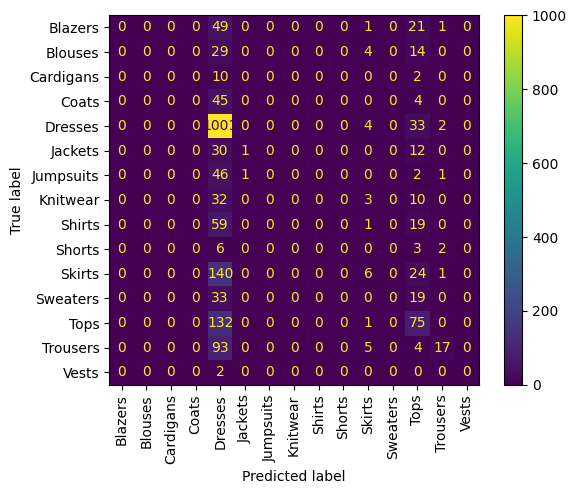

In [ ]:
matrix = confusion_matrix(test_dataset.true_labels(True), pred_labels)
ConfusionMatrixDisplay(matrix, display_labels=labels).plot(xticks_rotation="vertical")
